C:\Users\Forwa\AppData\Local\Temp\ipykernel_14776\1152796292.py:21: RuntimeWarning: divide by zero encountered in divide
  B_y = mu_0 * current_strength / (2 * np.pi * Y)  # Simplified model


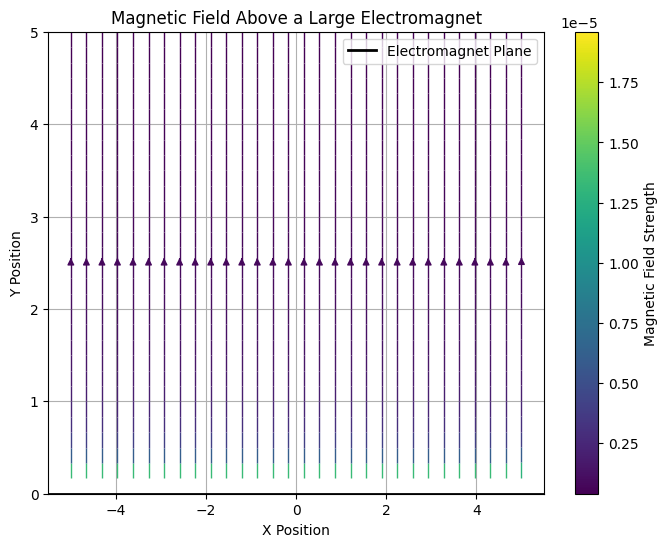

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the simulation space
x_min, x_max = -5, 5
y_min, y_max = 0, 5  # Only above the electromagnet (y >= 0)
grid_size = 50  # Resolution of the grid

# Create a grid of points
x = np.linspace(x_min, x_max, grid_size)
y = np.linspace(y_min, y_max, grid_size)
X, Y = np.meshgrid(x, y)

# Parameters for the electromagnet
current_strength = 10  # Arbitrary current magnitude
mu_0 = 4 * np.pi * 1e-7  # Permeability of free space

# Approximate the magnetic field above the plane electromagnet
# The field is assumed to be mostly uniform and vertical above the plane
B_x = np.zeros_like(X)
B_y = mu_0 * current_strength / (2 * np.pi * Y)  # Simplified model

# Plot the field
plt.figure(figsize=(8, 6))
plt.streamplot(X, Y, B_x, B_y, color=B_y, cmap='viridis', linewidth=1)

# Plot the electromagnet as a line
plt.axhline(0, color='black', linewidth=2, label="Electromagnet Plane")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Magnetic Field Above a Large Electromagnet")
plt.colorbar(label="Magnetic Field Strength")
plt.legend()
plt.grid()
plt.show()


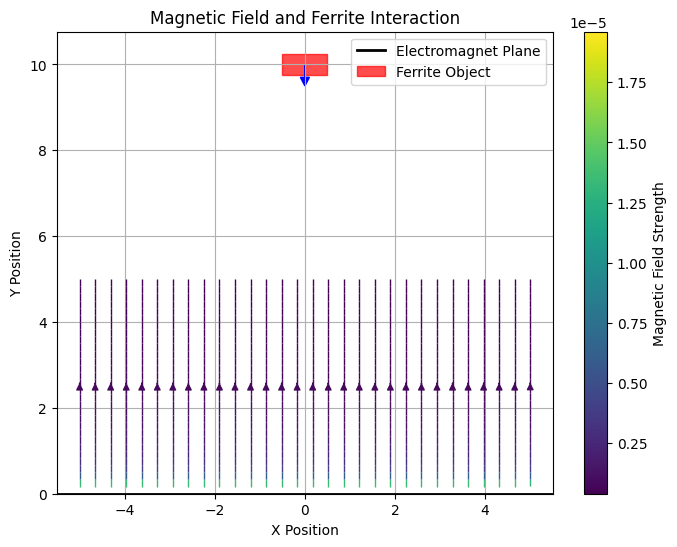

-4.0833333333333375e-07


In [13]:
# Define the ferrite object properties
ferrite_x = 0  # Positioned above the center of the electromagnet
ferrite_y = 10  # Initial height
ferrite_width = 1  # Width of the object
ferrite_height = 0.5  # Height of the object
ferrite_magnetization = 5  # Arbitrary magnetization strength

# Compute the force on the ferrite object
# Magnetic force is approximated as F = (m ⋅ ∇) B
# Since B is mostly vertical, we focus on the gradient in the y-direction
dy = y[1] - y[0]  # Grid spacing
B_y_grad = np.gradient(B_y, dy, axis=0)  # Compute the gradient in y-direction

# Interpolate the force at the ferrite position
ferrite_idx_x = np.argmin(np.abs(x - ferrite_x))
ferrite_idx_y = np.argmin(np.abs(y - ferrite_y))

force_y = ferrite_magnetization * B_y_grad[ferrite_idx_y, ferrite_idx_x]  # Force in y-direction

# Visualization
plt.figure(figsize=(8, 6))
plt.streamplot(X, Y, B_x, B_y, color=B_y, cmap='viridis', linewidth=1)
plt.axhline(0, color='black', linewidth=2, label="Electromagnet Plane")

# Plot the ferrite object
plt.gca().add_patch(plt.Rectangle((ferrite_x - ferrite_width / 2, ferrite_y - ferrite_height / 2),
                                  ferrite_width, ferrite_height, color='red', alpha=0.7, label="Ferrite Object"))

# Annotate force direction
plt.arrow(ferrite_x, ferrite_y, 0, 0.3 * np.sign(force_y), head_width=0.2, head_length=0.2, fc='blue', ec='blue')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Magnetic Field and Ferrite Interaction")
plt.colorbar(label="Magnetic Field Strength")
plt.legend()
plt.grid()
plt.show()

# Display computed force
print(force_y)


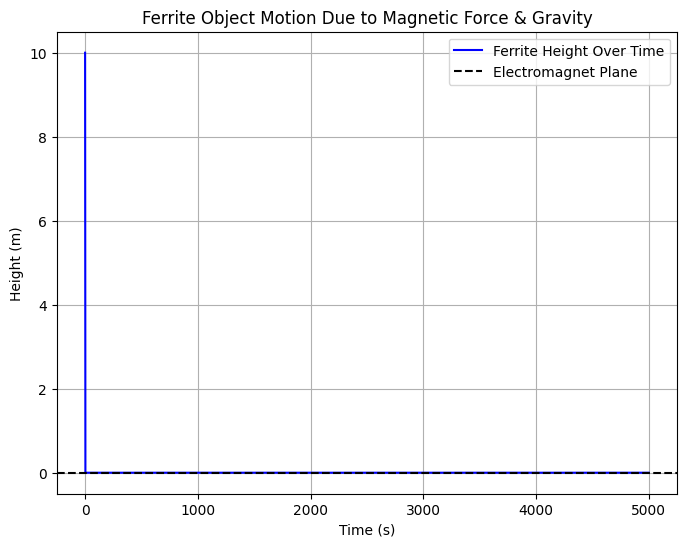

(np.float64(-8.166666666666674e-06), 0.0981, np.float64(-0.09810816666666668))

In [20]:
# Define physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
mass = 0.01  # Assume ferrite has a mass of 10g

# Compute gravitational force
force_gravity = mass * g  # F = mg

# Recalculate the force on the ferrite with new height
ferrite_y = 10  # New initial height

# Find the closest index for interpolation
ferrite_idx_y = np.argmin(np.abs(y - ferrite_y))

# Compute magnetic force
ferrite_magnetization = 100  # Arbitrary magnetization strength
force_magnetic = ferrite_magnetization * B_y_grad[ferrite_idx_y, ferrite_idx_x]

# Compute net force
force_net = force_magnetic - force_gravity  # Opposing gravitational force

# Perform motion simulation with updated forces

# Simulation parameters
time_step = 0.01  # Small time step for integration
num_steps = 500000   # Total number of steps

# Initialize position and velocity
y_positions = [ferrite_y]
y_velocity = 0  # Initial velocity

# Numerical integration using Euler's method
for _ in range(num_steps):
    # Compute acceleration using Newton's second law: F = ma
    acceleration = force_net / mass
    
    # Update velocity and position
    y_velocity += acceleration * time_step
    new_y_position = y_positions[-1] + y_velocity * time_step

    # Prevent the object from moving below the electromagnet
    if new_y_position < 0:
        new_y_position = 0
        y_velocity = 0  # Stop movement upon impact

    y_positions.append(new_y_position)

# Time array for plotting
time_array = np.linspace(0, num_steps * time_step, num_steps + 1)

# Plot the motion of the ferrite object with gravity included
plt.figure(figsize=(8, 6))
plt.plot(time_array, y_positions, label="Ferrite Height Over Time", color='b')
plt.axhline(0, color='black', linestyle='--', label="Electromagnet Plane")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("Ferrite Object Motion Due to Magnetic Force & Gravity")
plt.legend()
plt.grid()
plt.show()

# Display forces
force_magnetic, force_gravity, force_net


In [ ]:
# Reinitialize simulation parameters
y_positions = [ferrite_y]  # Start at 10m
y_velocity = 0  # Initial velocity
epsilon = 1e-6

# Perform numerical integration with repulsive force
for _ in range(num_steps):
    # Get the current position
    current_y = y_positions[-1]

    # Prevent the object from going too high (arbitrary limit for stability)
    if current_y > 50:  # Just a safety cap
        break

    # Compute updated magnetic field at the new position
    B_y_current = mu_0 * current_strength / (2 * np.pi * (current_y + epsilon))
    
    # Compute gradient of B_y at the current position (approximate derivative)
    B_y_grad_current = -mu_0 * current_strength / (2 * np.pi * (current_y + epsilon) ** 2)

    # Apply repulsion: Reverse the magnetic force direction
    force_magnetic = -ferrite_magnetization * B_y_grad_current  # Negative sign for repulsion

    # Compute new net force (Magnetic - Gravitational force)
    force_net = force_magnetic - force_gravity  # Still subtract gravity

    # Compute acceleration using Newton's second law: F = ma
    acceleration = force_net / mass

    # Update velocity and position using Euler integration
    y_velocity += acceleration * time_step
    new_y_position = current_y + y_velocity * time_step

    # Ensure it doesn't go below the electromagnet
    if new_y_position < 0:
        new_y_position = 0
        y_velocity = 0

    y_positions.append(new_y_position)

# Generate time array
time_array = np.linspace(0, len(y_positions) * time_step, len(y_positions))

# Plot updated motion with repulsive magnetic force
plt.figure(figsize=(8, 6))
plt.plot(time_array, y_positions, label="Ferrite Height Over Time", color='b')
plt.axhline(0, color='black', linestyle='--', label="Electromagnet Plane")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("Ferrite Object Motion with Repulsive Magnetic Force")
plt.legend()
plt.grid()
plt.show()

# Display final forces at the last computed step
force_magnetic, force_gravity, force_net


NameError: name 'epsilon' is not defined